# Fastcampus_EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [3]:
df = pd.read_csv('./data/2022-07-04_bobjo_db.csv', parse_dates=["completed_at","marketing_start_at"])

In [4]:
df = df.drop(columns=['month','completed_ymd','hour'])

In [5]:
df['OrderCycle'] = df['completed_at'].dt.strftime('%y.%m')
df.head()

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at,OrderCycle
0,970634,504760,201435,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,미적용,0,110500,COMM,VBANK,개발자 커리어,2018-11-11,21.03
1,970650,432862,203178,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,미적용,0,116000,COMM,CARD,영상 편집,2020-12-02,21.03
2,970657,72297,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090,190900,COMM,CARD,프로그래밍,2021-03-04,21.03
3,970656,72297,204246,ORDER,CANCELLED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,미적용,0,190900,COMM,CARD,프로그래밍,2021-03-04,21.03
4,970658,478028,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,117500,COMM,CARD,PPT/보고서,2019-11-14,21.03


# Cohort Analysis

## 사용자 유지율

In [6]:
df = df.set_index('customer_id')

first_order= df.groupby(df.index).completed_at.min()
first_order = first_order.dt.strftime('%y.%m')
df['FirstOrder'] = first_order
df = df.reset_index()

In [7]:
cohorts = df.groupby(['FirstOrder', 'OrderCycle'])['customer_id'].nunique()
cohorts = cohorts.reset_index()
cohorts = cohorts.rename({'customer_id':'TotalUsers'},axis=1)

In [8]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()

In [9]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [10]:
cohorts['CohortPeriod']=cohortperiod
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)


cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()



FirstOrder
21.03     3068
21.04    10178
21.05    10243
21.06     8874
21.07     7911
Name: TotalUsers, dtype: int64

In [11]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

FirstOrder,21.03,21.04,21.05,21.06,21.07,21.08,21.09
CohortPeriod,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.141134,0.103164,0.143903,0.078206,0.116799,0.114939,NaN
2,0.083116,0.072608,0.045299,0.037525,0.032486,NaN,NaN
3,0.068449,0.056986,0.035244,0.024904,NaN,NaN,NaN
4,0.058018,0.043820,0.025286,NaN,NaN,NaN,NaN
5,0.062581,0.035862,NaN,NaN,NaN,NaN,NaN
6,0.037158,NaN,NaN,NaN,NaN,NaN,NaN


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


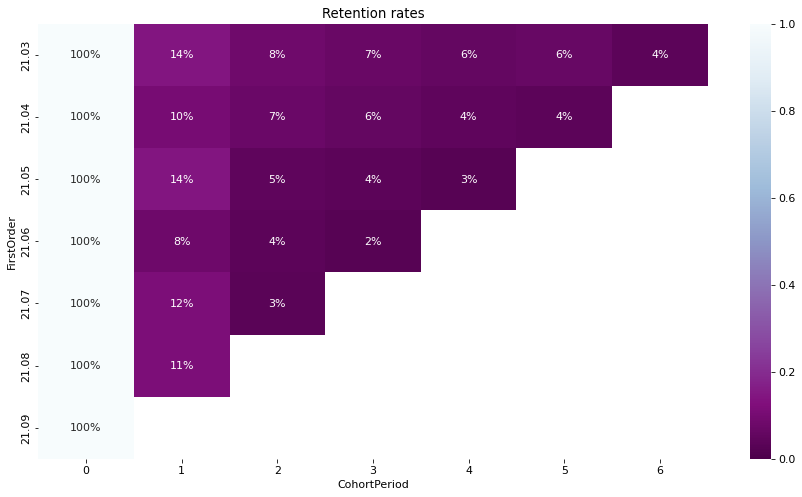

In [12]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=user_retention.T,annot = True,fmt = '.0%',vmin = 0.0,vmax = 1.0,cmap="BuPu_r")
plt.show()

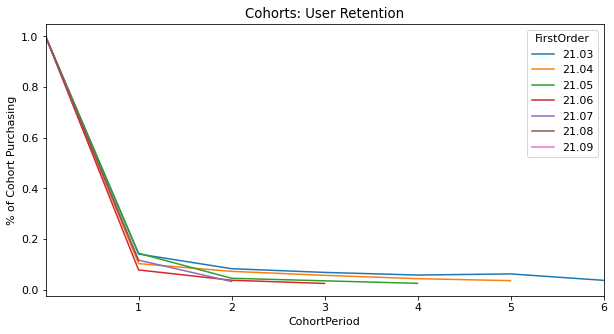

In [13]:
user_retention[['21.03','21.04','21.05','21.06','21.07','21.08','21.09']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(0, 6)
plt.ylabel('% of Cohort Purchasing');

## 재구매 고객 비율

In [14]:
order_df = df.loc[(df['type'] == 'PAYMENT') & (df['state']=='COMPLETED'),:]
order_df

,customer_id,id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at,OrderCycle,FirstOrder
2,72297,970657,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090,190900,COMM,CARD,프로그래밍,2021-03-04,21.03,21.03
4,478028,970658,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,117500,COMM,CARD,PPT/보고서,2019-11-14,21.03,21.03
8,478033,970669,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,116000,COMM,CARD,영상 편집,2020-12-02,21.03,21.03
10,469860,970671,203644,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,미적용,0,263000,COMM,CARD,부동산/금융,2020-11-27,21.03,21.03
14,478035,970676,203720,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,111000,COMM,CARD,프론트엔드 개발,2021-02-02,21.03,21.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101085,669238,1364969,204286,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 3D 디자인 툴,디자인,올인원,2021-09-25 13:39:26,212000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000,232000,INICIS,CARD,디자인툴,2021-04-23,21.09,21.09
101086,384003,1364976,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-09-25 13:46:29,149000,미적용,0,149000,KAKAO,CARD,영상 편집,2020-12-02,21.09,21.05
101087,670891,1364991,203935,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발,프로그래밍,올인원,2021-09-25 14:01:26,159000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000,179000,INICIS,CARD,백엔드 개발,2021-05-31,21.09,21.09
101090,640697,1364996,205365,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기,영상/3D,올인원,2021-09-25 14:17:41,96000,[WELCOME] 온라인 강의 2만원 할인쿠폰,20000,116000,INICIS,VBANK,영상 편집,2021-06-15,21.09,21.09


In [15]:
order_df = order_df.set_index('customer_id')

first_order= order_df.groupby(order_df.index).completed_at.min()
first_order = first_order.dt.strftime('%y.%m')
order_df['FirstOrder'] = first_order
order_df = order_df.reset_index()

In [16]:
cohorts = order_df.groupby(['FirstOrder', 'OrderCycle'])['customer_id'].nunique()
cohorts = cohorts.reset_index()
cohorts = cohorts.rename({'customer_id':'TotalUsers'},axis=1)

In [17]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()

In [18]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [19]:
cohorts['CohortPeriod']=cohortperiod
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)


cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()



FirstOrder
21.03    1994
21.04    6853
21.05    6837
21.06    6048
21.07    5924
Name: TotalUsers, dtype: int64

In [20]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

FirstOrder,21.03,21.04,21.05,21.06,21.07,21.08,21.09
CohortPeriod,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.091274,0.073107,0.110282,0.053075,0.110230,0.102842,NaN
2,0.061685,0.053553,0.036858,0.036376,0.031735,NaN,NaN
3,0.050652,0.046841,0.036566,0.022817,NaN,NaN,NaN
4,0.042126,0.040420,0.024718,NaN,NaN,NaN,NaN
5,0.057673,0.037648,NaN,NaN,NaN,NaN,NaN
6,0.034604,NaN,NaN,NaN,NaN,NaN,NaN


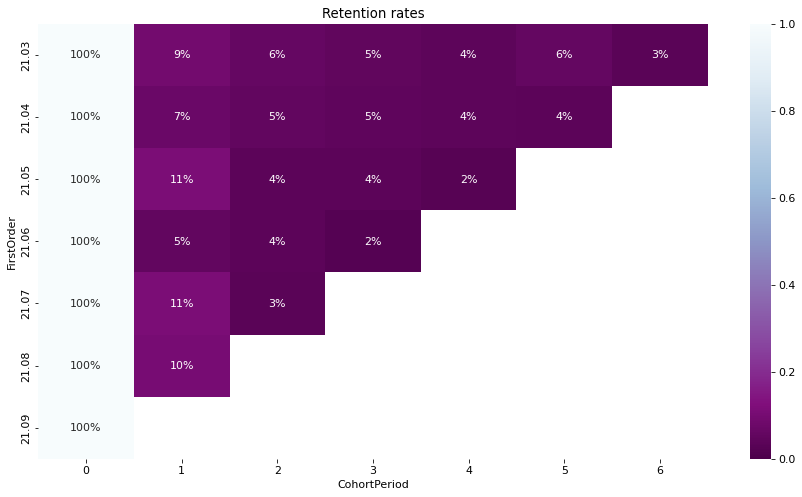

In [21]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=user_retention.T,annot = True,fmt = '.0%',vmin = 0.0,vmax = 1.0,cmap="BuPu_r")
plt.show()

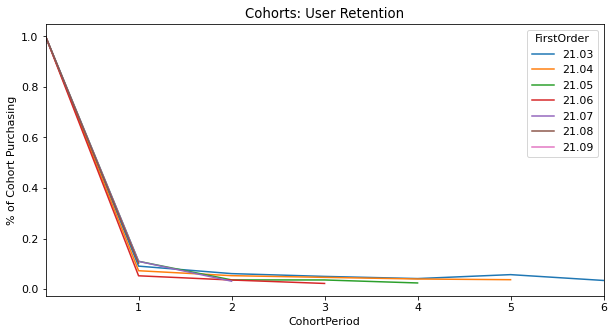

In [22]:
user_retention[['21.03','21.04','21.05','21.06','21.07','21.08','21.09']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(0, 6)
plt.ylabel('% of Cohort Purchasing');

# RFM Analysis

In [23]:
print('Min completed_at :',order_df.completed_at.dt.date.min(),'max completed_at:',
       order_df.completed_at.dt.date.max())

order_df.head(3)

Min completed_at : 2021-03-28 max completed_at: 2021-09-25


,customer_id,id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at,OrderCycle,FirstOrder
0,72297,970657,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090,190900,COMM,CARD,프로그래밍,2021-03-04,21.03,21.03
1,478028,970658,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,117500,COMM,CARD,PPT/보고서,2019-11-14,21.03,21.03
2,478033,970669,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000,116000,COMM,CARD,영상 편집,2020-12-02,21.03,21.03


## Recency

In [24]:
recency_df = order_df.groupby('customer_id')['completed_at'].max().reset_index()
recency_df.columns = ['customer_id', 'LastPurchaseDate']
# snapshot_date = df['event_timestamp'].max() + dt.timedelta(days=1)
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x : (order_df['completed_at'].max() - x).days)
recency_df = recency_df.drop(columns=['LastPurchaseDate'])
recency_df.head()

,customer_id,Recency
0,46,145
1,47,77
2,79,179
3,96,3
4,153,9


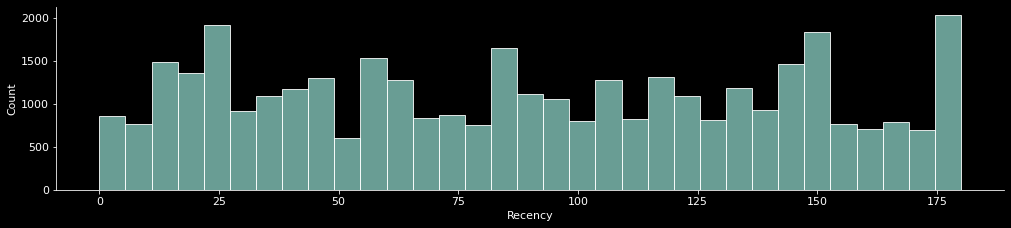

In [25]:
# Recency 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = recency_df, x='Recency')
plt.gcf().set_size_inches(16.5, 3)


## Frequency

In [26]:
frequency_df = order_df.drop_duplicates(['customer_id','id'],keep='first')
frequency_df = frequency_df.groupby('customer_id')['id'].count().reset_index()
frequency_df.columns = ['customer_id','Frequency']
frequency_df.head()

,customer_id,Frequency
0,46,1
1,47,2
2,79,1
3,96,1
4,153,3


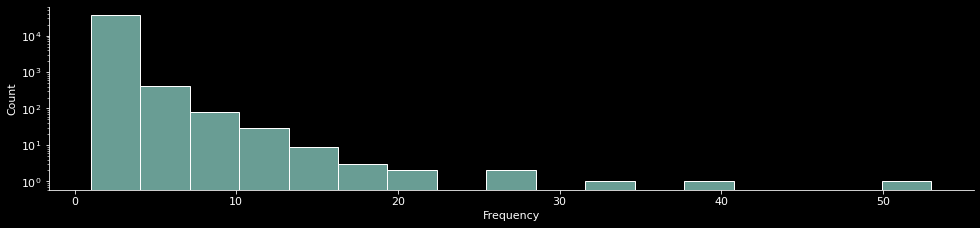

In [27]:
# Frequency 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = frequency_df, x='Frequency')
plt.yscale('log')
plt.gcf().set_size_inches(16.5, 3)

## Monetary

In [28]:
monetary_df = order_df.groupby('customer_id')['transaction_amount'].sum().reset_index()
monetary_df.columns = ['customer_id','Monetary']
monetary_df.head()

,customer_id,Monetary
0,46,540000
1,47,243500
2,79,0
3,96,289000
4,153,517000


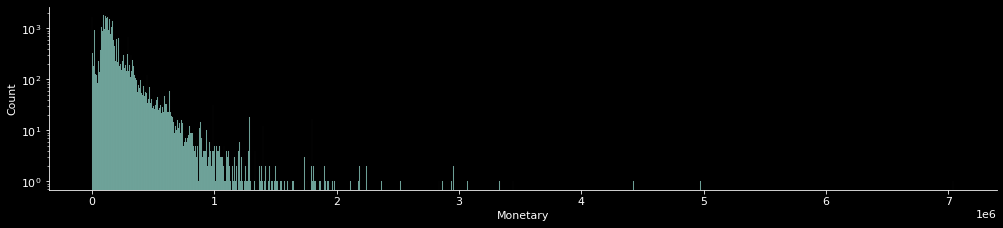

In [29]:
# Monetary 분포 확인
plt.style.use(['dark_background'])

sns.displot(data = monetary_df, x='Monetary')
plt.yscale('log')
plt.gcf().set_size_inches(16.5, 3)


## merge

In [30]:
rf = recency_df.merge(frequency_df,on=['customer_id'])
rfm = rf.merge(monetary_df,on=['customer_id'])
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,46,145,1,540000
1,47,77,2,243500
2,79,179,1,0
3,96,3,1,289000
4,153,9,3,517000


/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

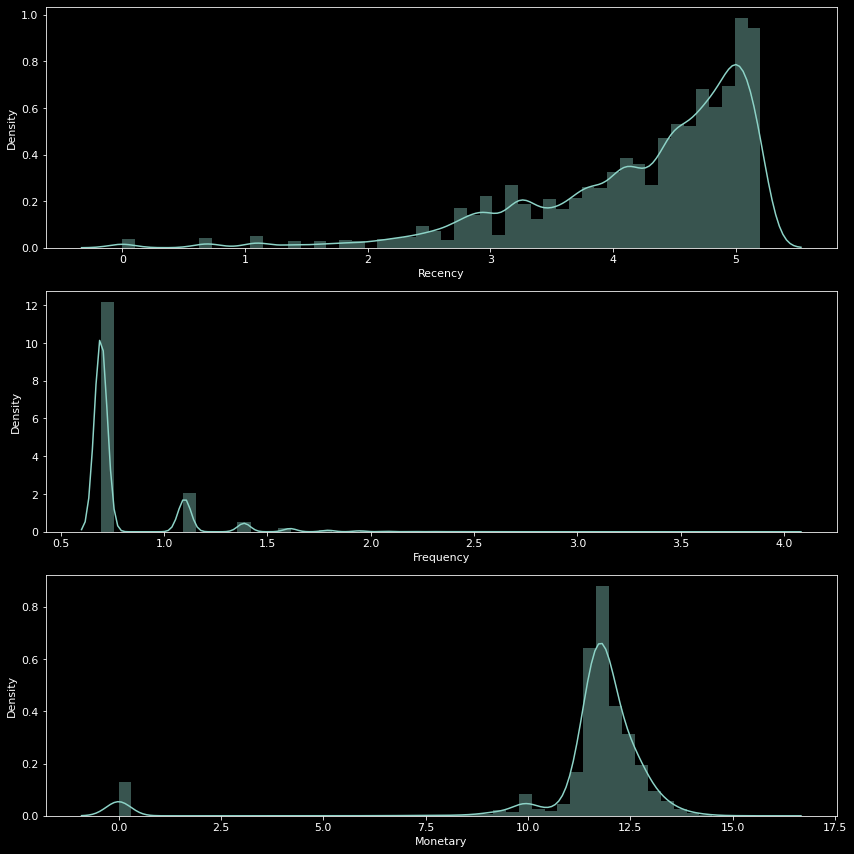

In [31]:
plt.style.use(['dark_background'])

rfm = rfm.set_index('customer_id')

rfm_log = (rfm+1).apply(np.log, axis = 1)

f,ax = plt.subplots(figsize=(12, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.Monetary, label = 'Monetary')
plt.tight_layout()
plt.show()

# RFM

## data scailing

In [32]:
from sklearn.preprocessing import MinMaxScaler


scaled = MinMaxScaler().fit_transform(rfm)
rfm_df = pd.DataFrame(data=scaled, columns=rfm.columns, index=rfm.index)

rfm_df['Recency'] = 1-rfm_df['Recency'] # 낮은고객일수록 가치가 높아서 역순취해서 높을수록 가치가 높게 해주기 위함.
rfm_df['Score'] = rfm_df['Recency'] + rfm_df['Frequency'] + rfm_df['Monetary']
rfm_df = rfm_df.reset_index()
rfm_df


,customer_id,Recency,Frequency,Monetary,Score
0,46,0.194444,0.000000,0.076696,0.271141
1,47,0.572222,0.019231,0.034584,0.626037
2,79,0.005556,0.000000,0.000000,0.005556
3,96,0.983333,0.000000,0.041047,1.024380
4,153,0.950000,0.038462,0.073430,1.061891
...,...,...,...,...,...
37089,670748,1.000000,0.000000,0.021873,1.021873
37090,670787,1.000000,0.000000,0.019742,1.019742
37091,670817,1.000000,0.000000,0.024429,1.024429
37092,670833,1.000000,0.000000,0.024003,1.024003


In [33]:
# score만 다시 scailing 
score = rfm_df[['customer_id','Score']]
score = score.set_index('customer_id')
scaled = (MinMaxScaler().fit_transform(score)) * 100
score_df = pd.DataFrame(data=scaled, columns=score.columns, index=score.index)
score_df = score_df.reset_index()

rfm_df['Score'] = score_df['Score']
rfm_df['Score'] = round(rfm_df['Score'],0)

rfm_df

,customer_id,Recency,Frequency,Monetary,Score
0,46,0.194444,0.000000,0.076696,9.0
1,47,0.572222,0.019231,0.034584,21.0
2,79,0.005556,0.000000,0.000000,0.0
3,96,0.983333,0.000000,0.041047,34.0
4,153,0.950000,0.038462,0.073430,36.0
...,...,...,...,...,...
37089,670748,1.000000,0.000000,0.021873,34.0
37090,670787,1.000000,0.000000,0.019742,34.0
37091,670817,1.000000,0.000000,0.024429,34.0
37092,670833,1.000000,0.000000,0.024003,34.0


## 점수 구간화

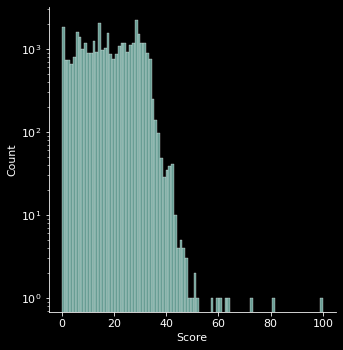

In [34]:
# score 구간 확인
sns.displot(rfm_df['Score'])
plt.yscale('log')
plt.show()

In [35]:
# ▶ 점수별로 고객의 등급을 부여
# 60점 이상 1
# 40~60점 2
# 20~40점 3
# 10~20점 4
# 0~10점 5

rfm_df['Grade'] = rfm_df['Score'].apply(lambda x : '1' if x>=60 else 
                                  ('2' if x>=40 else 
                                   ('3' if x>=20 else 
                                    ('4' if x>=10 else '5'))))
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,Score,Grade
0,46,0.194444,0.000000,0.076696,9.0,5
1,47,0.572222,0.019231,0.034584,21.0,3
2,79,0.005556,0.000000,0.000000,0.0,5
3,96,0.983333,0.000000,0.041047,34.0,3
4,153,0.950000,0.038462,0.073430,36.0,3


In [36]:
# 원본에 고객의 등급 data merge
df = order_df.merge(rfm_df, left_on=['customer_id'], right_on=['customer_id'], how='left')
df.head()

,customer_id,id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,method,subcategory_title,marketing_start_at,OrderCycle,FirstOrder,Recency,Frequency,Monetary,Score,Grade
0,72297,970657,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,CARD,프로그래밍,2021-03-04,21.03,21.03,0.766667,0.076923,0.072906,31.0,3
1,478028,970658,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,CARD,PPT/보고서,2019-11-14,21.03,21.03,0.000000,0.000000,0.013848,0.0,5
2,478033,970669,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,...,CARD,영상 편집,2020-12-02,21.03,21.03,0.000000,0.000000,0.013635,0.0,5
3,469860,970671,203644,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,...,CARD,부동산/금융,2020-11-27,21.03,21.03,0.000000,0.000000,0.037354,1.0,5
4,478035,970676,203720,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,...,CARD,프론트엔드 개발,2021-02-02,21.03,21.03,0.000000,0.000000,0.012925,0.0,5


# 월별 이용고객 현황

In [37]:
cus_df = df.groupby('OrderCycle')['customer_id'].nunique().reset_index()

Min completed_at : 2021-03-28 max completed_at: 2021-09-25


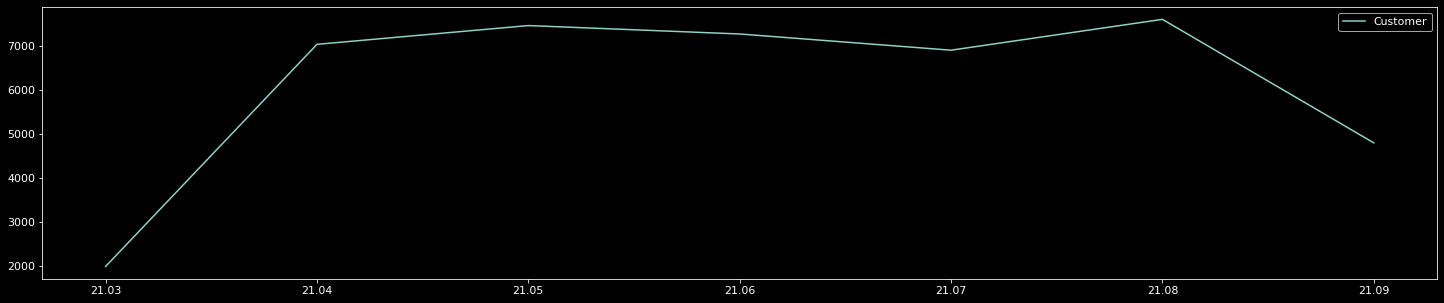

In [38]:
# 마지막에 그래프가 내려가있는이유는 8월4일 1주차정도밖에 데이터가 없기때문.
plt.plot(cus_df['OrderCycle'], cus_df['customer_id'], label='Customer');
plt.legend();
plt.gcf().set_size_inches(25, 5)
print('Min completed_at :',df.completed_at.dt.date.min(),'max completed_at:',
       df.completed_at.dt.date.max())

# 주별 Grade 이용 비중

In [39]:
grade_df = df.groupby(['OrderCycle','Grade'])['customer_id'].nunique().reset_index()

In [41]:
df_pivot = pd.pivot_table(grade_df,            # 피벗할 데이터프레임
                      index = 'OrderCycle',        # 행 위치에 들어갈 열
                      columns = 'Grade',       # 열 위치에 들어갈 열
                      values = 'customer_id')   # 데이터로 사용할 열 

df_pivot.fillna(0, inplace=True)
df_pivot['total'] = df_pivot['1'] + df_pivot['2'] + df_pivot['3'] + df_pivot['4'] + df_pivot['5'] 


df_pivot.iloc[:,0] = (df_pivot.iloc[:,0] / df_pivot['total'])
df_pivot.iloc[:,1] = (df_pivot.iloc[:,1] / df_pivot['total'])
df_pivot.iloc[:,2] = (df_pivot.iloc[:,2] / df_pivot['total'])
df_pivot.iloc[:,3] = (df_pivot.iloc[:,3] / df_pivot['total'])
df_pivot.iloc[:,4] = (df_pivot.iloc[:,4] / df_pivot['total'])


df_pivot.drop(['total'], axis=1, inplace=True)
df_pivot

Grade,1,2,3,4,5
OrderCycle,,,,,
21.03,0.001505,0.005015,0.094283,0.053159,0.846038
21.04,0.000995,0.009240,0.091969,0.065956,0.831841
21.05,0.000804,0.007908,0.095698,0.546173,0.349417
21.06,0.000825,0.010041,0.135351,0.853783,0.000000
21.07,0.001014,0.011301,0.878731,0.108954,0.000000
21.08,0.000789,0.010787,0.988424,0.000000,0.000000
21.09,0.001459,0.028756,0.969785,0.000000,0.000000


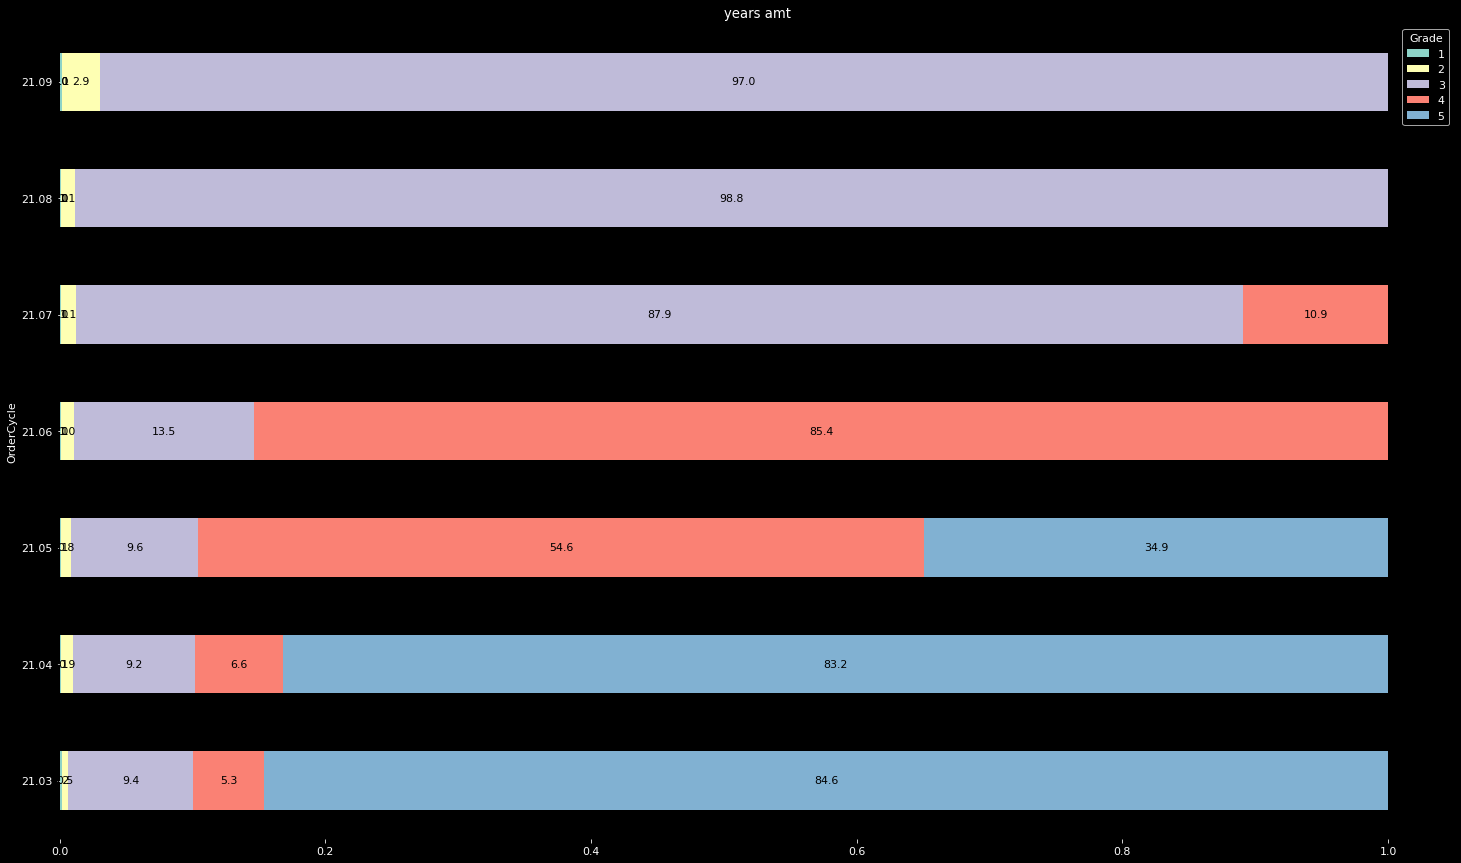

In [42]:
# 월별이용고객현황으로 보아 말일에 이용이 많은 것으로 보이고, 1번 vvip는 거의 없다시피하나
# vip(2)는 점점 증가하고 있으며, 노말(3) 고객도 높은 증가세를 보임.
import warnings
warnings.filterwarnings('ignore')
plt.style.use(['dark_background'])

ax = df_pivot.plot(kind='barh', stacked=True, title="years amt", rot=0);
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f"%(width*100), xy=(left+width/2, bottom+height/2), ha='center', va='center', color='black');

plt.box(False)
plt.gcf().set_size_inches(25, 15)
plt.show()